# Natural Language Processing Project

>Goals:
- Build a dataset of 100 Github repositories' readme text
- Explore the text of the readme's and find connections to programming language
- Build a classification ML model that predicts the programming language used in a repo based on readme content. 

In [1]:
import numpy as np
import pandas as pd
import json
import re
import warnings
warnings.filterwarnings("ignore")

from prepare import add_columns, split_repo_data
from explore import word_string, word_freq, word_counts, word_cloud
from explore import ngrams, plot_ngrams
import seaborn as sns
import matplotlib.pyplot as plt

Prepare module loaded.


---
## Acquire

In [2]:
# raw data
df = pd.read_json('repos.json')

In [3]:
# summary of data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 599 entries, 0 to 598
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   language  599 non-null    object
 1   repo      599 non-null    object
 2   content   599 non-null    object
dtypes: object(3)
memory usage: 18.7+ KB


In [4]:
df.head()

,language,repo,content
0,JavaScript,facebook/react,React · \nReact is a JavaScript library for...
1,JavaScript,d3/d3,D3: Data-Driven Documents\n\nD3 (or D3.js) is ...
2,JavaScript,vuejs/vue,\n\n\n\n\n\n\n\n\n\n\nSupporting Vue.js\nVue.j...
3,JavaScript,axios/axios,axios\n\n\n\n\n\n\n\n\nPromise based HTTP clie...
4,JavaScript,facebook/create-react-app,Create React App \n\nCreate React apps with n...


In [5]:
# how many of each language
df.language.value_counts()

JavaScript    300
Python        299
Name: language, dtype: int64

In [6]:
# number of unique repos
df.repo.nunique()

581

<div class="alert alert-block alert-info">
<b>Summary</b>:
    <li> Data acquired using the BeautifulSoup library </li>
<li> Used helper functions to get requests to the first 30 search pages of most starred repos for Javascript and Python. </li>
 <li>Used helper function to parse HTML to find certain elements that contained the <i>programming language</i>, <i>repo-sub url</i>, and the <i>readme content</i> for each repo among said pages and saved to a DataFrame. Stored as a json file locally for reproduction.</li>
</div>

---
## Prepare

In [7]:
# prepared data
df = pd.read_json('repos_clean.json').reset_index().drop(columns='index')

In [8]:
# adds list of words column and length of cleaned doc
df = add_columns(df)

In [9]:
# prepped data summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581 entries, 0 to 580
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   language    581 non-null    object
 1   repo        581 non-null    object
 2   content     581 non-null    object
 3   stemmed     581 non-null    object
 4   lemmatized  581 non-null    object
 5   clean       581 non-null    object
 6   words       581 non-null    object
 7   doc_length  581 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 36.4+ KB


In [10]:
# split the data
train, validate, test = split_repo_data(df)

In [11]:
print(train.language.value_counts(), '\n')
print(validate.language.value_counts(), '\n')
print(test.language.value_counts())
train.head(3)

JavaScript    180
Python        168
Name: language, dtype: int64 

JavaScript    60
Python        56
Name: language, dtype: int64 

JavaScript    60
Python        57
Name: language, dtype: int64


,language,clean,words,doc_length
277,Python,welcome streamlit fastest way build share data...,"[welcome, streamlit, fastest, way, build, shar...",202
97,JavaScript,translation espaol deutsch portugus trke add f...,"[translation, espaol, deutsch, portugus, trke,...",633
501,Python,plotlypy latest release user forum pypi downlo...,"[plotlypy, latest, release, user, forum, pypi,...",399


<div class="alert alert-block alert-info">
<b>Summary</b>:
    <li>Readme content is normalized, tokenized, stemmed, lemmatized, and stopwords are removed to produce "clean" content.</li>
    <li>Duplicate repos are removed and 2 columns are created</li>
    <li>The data is split into train, validate, and, test; stratifying on the programming language.</li>
</div>

---
## Explore

> **What's the proportion of each language in our data?**

In [12]:
# total counts and proportions of each language 
labels = pd.concat([train.language.value_counts(), 
                    train.language.value_counts(normalize=True)], axis=1) 
labels.columns = ['n', 'percent']
labels

,n,percent
JavaScript,180,0.517241
Python,168,0.482759


> **What are the most common words in READMEs?**

In [13]:
# used helper functions from explore.py
js_words, py_words, all_words = word_string(train)
js_freq, py_freq, all_freq = word_freq(js_words, py_words, all_words)
word_counts = word_counts(js_freq, py_freq)

In [14]:
# more refined list that frequents one language as opposed to the other
print('20 Most Common Words')
refined_wordcounts = word_counts[(word_counts.prop_js <= .40) | (word_counts.prop_js >= .60)]
refined_wordcounts.sort_values(by=['all', 'prop_js'], ascending=False).head(20)

20 Most Common Words


,js,py,all,prop_js
python,32,1374,1406,0.022760
function,1032,373,1405,0.734520
data,384,830,1214,0.316310
react,1205,6,1211,0.995045
native,1051,27,1078,0.974954
default,670,363,1033,0.648596
library,330,606,936,0.352564
return,660,254,914,0.722101
object,638,265,903,0.706534
new,588,305,893,0.658455


> **Does the length of the README vary by programming language?**

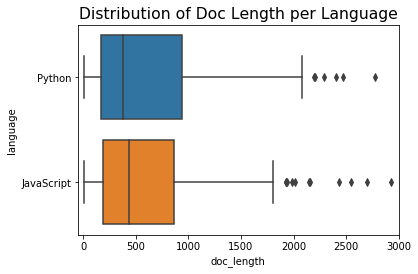

In [15]:
sns.boxplot(y=train.language, x=train.doc_length, orient="h")
plt.xlim(-50, 3000)
plt.rc('font', size=13)
plt.title('Distribution of Doc Length per Language')
plt.tight_layout()

In [16]:
# descriptive statistics for each languages' document length
train.groupby('language').doc_length.describe()

,count,mean,std,min,25%,50%,75%,max
language,,,,,,,,
JavaScript,180.0,935.266667,1530.272370,11.0,187.75,436.5,860.5,10505.0
Python,168.0,915.589286,1570.565409,3.0,171.25,382.0,940.0,10538.0


> **Do different programming languages use a different number of unique words?**

In [ ]:
word_cloud(js_words, py_words)

>**What are the highest frequencies of word combinations?** *ie. ngrams*

In [ ]:
# bigrams and trigrams for each language
js_bigrams, py_bigrams = ngrams(js_words, py_words, 2)
js_trigrams, py_trigrams = ngrams(js_words, py_words, 3)

In [ ]:
plot_ngrams(js_bigrams, py_bigrams, js_trigrams, py_trigrams)